# Implement arbitrary boundary conditions with discrete fourier transforms using shift function 

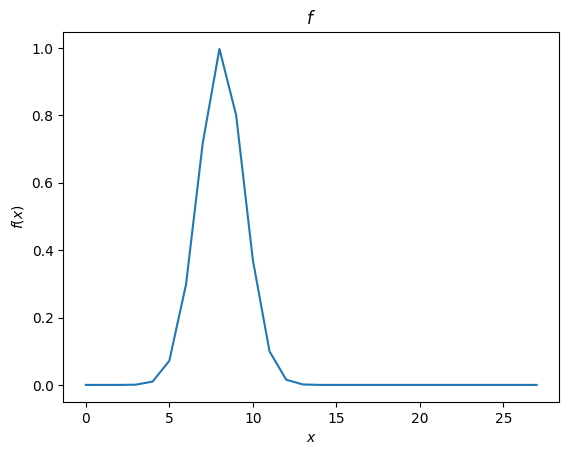

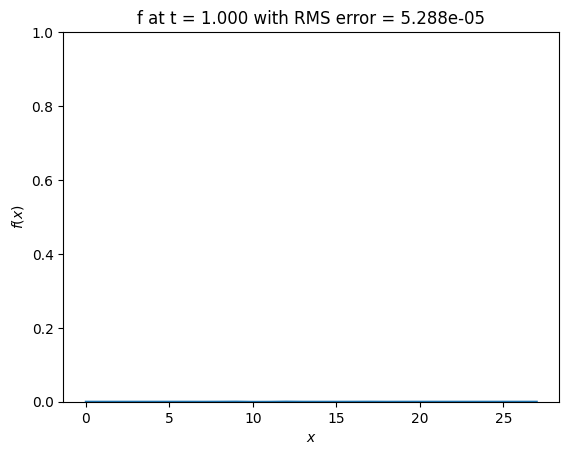

In [1]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 28
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
dt                = 1e-4
v                 = 1
t                 = 0.0
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 6
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_NTH_ORDER
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 5
def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

while t < tend:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = np.pad(homf, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homf, BC)
    ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
    ddf             = ddf.real
    #ddf             = sd.restoreBC      (ddf, BC).real
    if B.shape[0] > 1:
        ddf             = ddf + B[1]
        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

## Use an additional window

[0.        0.0954915 0.3454915 0.6545085 0.9045085 1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        0.9045085 0.6545085 0.3454915 0.0954915 0.       ]


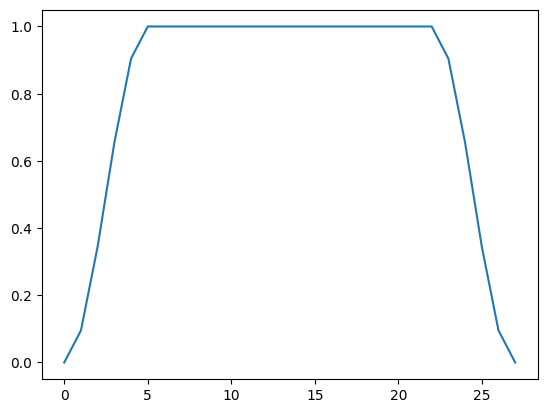

In [2]:

def absorbingPotential(x, L0_phys, L0_buf, L1_phys, L1_buf):
    y = np.zeros(x.shape)

    delta = L1_buf - L1_phys
    
    y[x <= L0_phys] = np.cos( np.pi * (x[x <= L0_phys] - L0_buf) / ( 2 * delta ) )**2
    y[x >= L1_phys] = np.cos( np.pi * (x[x >= L1_phys] - L1_buf) / ( 2 * delta ) )**2
    return y

V = absorbingPotential(x, (ghostBoundary - 1)*dx, 0, L - (ghostBoundary -1 ) * dx, 1) 

plt.plot(1-V)
print(1-V)

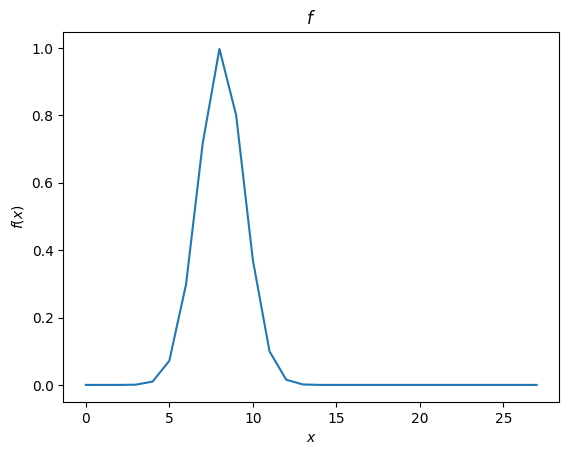

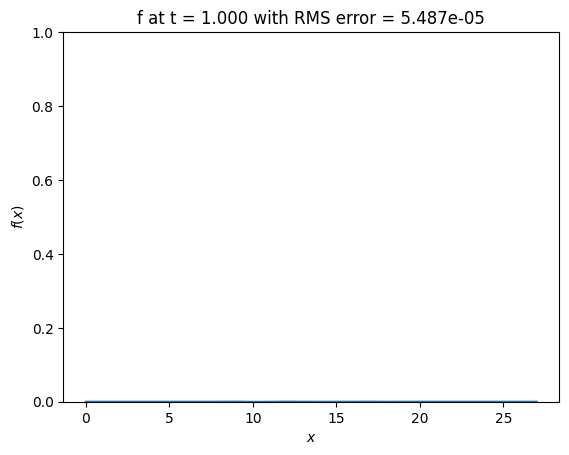

In [3]:
t = 0
f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()
m = 100
while t < tend:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = 5, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = homf * (1 - V) + homf * V * np.exp(-m * dt)
    homf            = np.pad(homf, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homf, BC)
    ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
    ddf             = ddf.real

    if B.shape[0] > 1:
        ddf             = ddf + B[1]
        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()